## Part Of Speech Tagging (5 pts)

<img src=https://i.stack.imgur.com/6pdIT.png width=320>

Unlike our previous experience with language modelling, this time around we learn the mapping between two different kinds of elements.

This setting is common for a range of useful problems:
* Speech Recognition - processing human voice into text
* Part Of Speech Tagging - for morphology-aware search and as an auxuliary task for most NLP problems
* Named Entity Recognition - for chat bots and web crawlers
* Protein structure prediction - for bioinformatics

Our current guest is part-of-speech tagging. As the name suggests, it's all about converting a sequence of words into a sequence of part-of-speech tags. We'll use a reduced tag set for simplicity:

### POS-tags
- ADJ - adjective (new, good, high, ...)
- ADP - adposition	(on, of, at, ...)
- ADV - adverb	(really, already, still, ...)
- CONJ	- conjunction	(and, or, but, ...)
- DET - determiner, article	(the, a, some, ...)
- NOUN	- noun	(year, home, costs, ...)
- NUM - numeral	(twenty-four, fourth, 1991, ...)
- PRT -	particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- .	- punctuation marks	(. , ;)
- X	- other	(ersatz, esprit, dunno, ...)

In [1]:
import nltk
import sys
import numpy as np
nltk.download('brown')
nltk.download('universal_tagset')
data = nltk.corpus.brown.tagged_sents(tagset='universal')
all_tags = ['#EOS#','#UNK#','ADV', 'NOUN', 'ADP', 'PRON', 'DET', '.', 'PRT', 'VERB', 'X', 'NUM', 'CONJ', 'ADJ']

data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])

[nltk_data] Error loading brown: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading universal_tagset: <urlopen error [Errno -2]
[nltk_data]     Name or service not known>


In [2]:
from sklearn.cross_validation import train_test_split
train_data,test_data = train_test_split(data,test_size=0.25,random_state=42)

/home/jheuristic/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from IPython.display import HTML, display
def draw(sentence):
    words,tags = zip(*sentence)
    display(HTML('<table><tr>{tags}</tr>{words}<tr></table>'.format(
                words = '<td>{}</td>'.format('</td><td>'.join(words)),
                tags = '<td>{}</td>'.format('</td><td>'.join(tags)))))
    
    
draw(data[11])
draw(data[10])
draw(data[7])

NOUN,ADP,NOUN,NOUN,NOUN,NOUN,VERB,ADV,VERB,ADP,DET,ADJ,NOUN,.,implementation,of,georgia's,automobile,title,law,was,also,recommended,by,the,outgoing,jury,.


PRON,VERB,ADP,DET,NOUN,.,VERB,NOUN,PRT,VERB,.,DET,NOUN,.,it,urged,that,the,city,``,take,steps,to,remedy,'',this,problem,.


NOUN,VERB,merger,proposed


### Building vocabularies

Just like before, we have to build a mapping from tokens to integer ids. This time around, our model operates on a word level, processing one word per RNN step. This means we'll have to deal with far larger vocabulary.

Luckily for us, we only receive those words as input i.e. we don't have to predict them. This means we can have a large vocabulary for free by using word embeddings.

In [4]:
from collections import Counter
word_counts = Counter()
for sentence in data:
    words,tags = zip(*sentence)
    word_counts.update(words)

all_words = ['#EOS#','#UNK#']+list(list(zip(*word_counts.most_common(10000)))[0])

Coverage = 0.92876


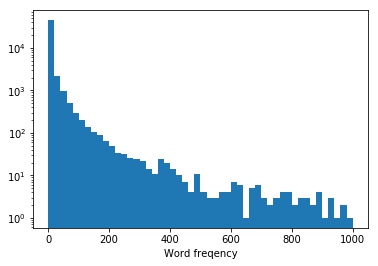

In [5]:
#let's measure what fraction of data words are in the dictionary
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(list(word_counts.values()),range=[0,1000],bins=50)
plt.xlabel("Word freqency")
plt.yscale('log')

print("Coverage = %.5f"%(float(sum(word_counts[w] for w in all_words)) / sum(word_counts.values())))

In [6]:
from collections import defaultdict
word_to_id = defaultdict(lambda:1,{word:i for i,word in enumerate(all_words)})
tag_to_id = {tag:i for i,tag in enumerate(all_tags)}

convert words and tags into fixed-size matrix

In [7]:
def to_matrix(lines,token_to_id,max_len=None,pad=0,dtype='int32',time_major=False):
    """Converts a list of names into rnn-digestable matrix with paddings added after the end"""
    
    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines),max_len],dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__,lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix



In [8]:
batch_words,batch_tags = zip(*[zip(*sentence) for sentence in data[-3:]])

print("Word ids:")
print(to_matrix(batch_words,word_to_id))
print("Tag ids:")
print(to_matrix(batch_tags,tag_to_id))

Word ids:
[[   2 3057    5    2 2238 1334 4238 2454    3    6   19   26 1070   69
     8 2088    6    3    1    3  266   65  342    2    1    3    2  315
     1    9   87  216 3322   69 1558    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  45   12    8  511 8419    6   60 3246   39    2    1    1    3    2
   845    1    3    1    3   10 9910    2    1 3470    9   43    1    1
     3    6    2 1046  385   73 4562    3    9    2    1    1 3250    3
    12   10    2  861 5240   12    8 8936  121    1    4]
 [  33   64   26   12  445    7 7346    9    8 3337    3    1 2811    3
     2  463  572    2    1    1 1649   12    1    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
Tag ids:
[[ 6  3  4  6  3  3  9  9  7 12  4  5  9  4  6  3 12  7  9  7  9  8  4  6
   3  7  6 13  3  4  6  3  9  4  3  7  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0

### Build model

Unlike our previous lab, this time we'll focus on a high-level keras interface to recurrent neural networks. It is as simple as you can get with RNN, allbeit somewhat constraining for complex tasks like seq2seq.

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

In [9]:
import theano, theano.tensor as T
import lasagne, lasagne.layers as L

input_words = T.imatrix("words[batch,time]")
reference_tags = T.imatrix("tags[batch,time]")
mask = T.neq(input_words,0)

l_in = L.InputLayer((None,None),input_words)
l_mask = L.InputLayer((None,None),mask)

l_emb = L.EmbeddingLayer(l_in,len(all_words),50)
l_rnn = L.RecurrentLayer(l_emb,64,mask_input=l_mask,nonlinearity=T.tanh)

tensor_softmax = lambda x: T.nnet.softmax(x.reshape([-1,x.shape[-1]])).reshape(x.shape)

l_out = L.DenseLayer(l_rnn,num_units=len(all_tags),
                     num_leading_axes=2,
                     nonlinearity=tensor_softmax)

In [10]:
tag_probas = L.get_output(l_out)

loss = T.nnet.categorical_crossentropy(tag_probas.reshape([-1,len(all_tags)]),
                                       reference_tags.ravel())
loss = T.mean(loss * mask.ravel())

updates = lasagne.updates.adam(loss,L.get_all_params(l_out,trainable=True))

predict_proba = theano.function([input_words],tag_probas,
                                allow_input_downcast=True)
train_step = theano.function([input_words,reference_tags],loss,updates=updates,
                             allow_input_downcast=True)

__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. Instead, we'll form batches on the fly using custom generator.

In [11]:
from tqdm import tnrange
def generate_batches(sentences,batch_size=32,max_len=None,pad=0):
    assert isinstance(sentences,np.ndarray),"Make sure sentences is q numpy array"
    indices = np.random.permutation(np.arange(len(sentences)))
    for start in tnrange(0,len(indices)-1,batch_size):
        batch_indices = indices[start:start+batch_size]
        batch_words,batch_tags = [],[]
        for sent in sentences[batch_indices]:
            words,tags = zip(*sent)
            batch_words.append(words)
            batch_tags.append(tags)

        batch_words = to_matrix(batch_words,word_to_id,max_len,pad)
        batch_tags = to_matrix(batch_tags,tag_to_id,max_len,pad)
        yield batch_words,batch_tags
        

We also have to compute test accuracy. The catch is that our input data comes with padding that should not affect accuracy in any way. Therefore, we'll have to write our own function for padding.

In [12]:
def compute_accuracy(predict_proba,data):
    test_words,test_tags = zip(*[zip(*sentence) for sentence in data])
    
    numerator = 0   # number of correct predictions
    denominator = 0 # total number of predictions
    
    for bx,by in generate_batches(data):
        #predict tags of shape [batch,length]    
        predicted_tags = predict_proba(bx).argmax(axis=-1)
        numerator += np.sum((predicted_tags == by) & (bx != 0))
        denominator += np.sum(bx != 0)
    
    #compute accurary excluding padding
    return float(numerator)/denominator


Finally we got to training

A Jupyter Widget


Accuracy = 0.94745


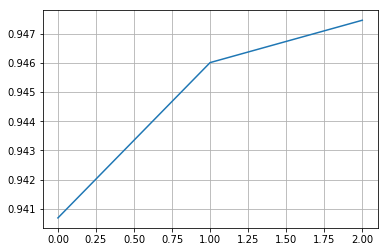

A Jupyter Widget

KeyboardInterrupt: 

In [13]:
from IPython.display import clear_output
history = []

for epoch in range(5):
    for bx,by in generate_batches(train_data):
        train_step(bx,by)
        
    history.append(compute_accuracy(predict_proba,test_data))
    clear_output(True)
    print("Epoch: %i, accuracy = %.5f"%(epoch + 1,history[-1]))
    plt.plot(history)
    plt.grid()
    plt.show()

Measure final accuracy on the whole test set.

In [15]:
acc = compute_accuracy(predict_proba,test_data)
print("Final accuracy: %.5f"%acc)

assert acc>0.94, "Sanity check failed. Make sure you didn't tweak hyperparameters too much."

A Jupyter Widget


Final accuracy: 0.94715


### Task I: getting all bidirectional

Since we're analyzing a full sequence, it's legal for us to look into future words.

A simple way to achieve that is to go both directions at once, making a __bidirectional RNN__.

In lasagne you can achieve that by using `backwards=True` and concatenating two recurrent layers:
* `forward = SomeLayer(...)`
* `backward = SomeLayer(...,backwards=True)`
* `bidirectional = L.concat([forward,backward],axis=-1)`

Your first task is to use such a layer in POS-tagger.

In [ ]:
input_words = T.imatrix("words[batch,time]")
reference_tags = T.imatrix("tags[batch,time]")
mask = T.neq(input_words,0)

l_in = L.InputLayer((None,None),input_words)
l_mask = L.InputLayer((None,None),mask)

### YOUR CODE HERE: define a model that utilizes bidirectional RecurrentLayer or GRU/LSTMLayer

l_out = <...>

In [ ]:
tag_probas = L.get_output(l_out)

loss = T.nnet.categorical_crossentropy(tag_probas.reshape([-1,len(all_tags)]),
                                       reference_tags.ravel())
loss = T.mean(loss * mask.ravel())

updates = lasagne.updates.adam(loss,L.get_all_params(l_out,trainable=True))

predict_proba = theano.function([input_words],tag_probas,
                                allow_input_downcast=True)
train_step = theano.function([input_words,reference_tags],loss,updates=updates,
                             allow_input_downcast=True)

In [ ]:
from IPython.display import clear_output
history = []

for epoch in range(5):
    for bx,by in generate_batches(train_data):
        train_step(bx,by)
        
    history.append(compute_accuracy(predict_proba,test_data))
    clear_output(True)
    print("Epoch: %i, accuracy = %.5f"%(epoch,history[-1]))
    plt.plot(history)
    plt.grid()
    plt.show()

In [ ]:
acc = compute_accuracy(predict_proba,test_data)
print("\nFinal accuracy: %.5f"%acc)

assert acc>0.96, "Bidirectional RNNs are better than this!"
print("Well done!")

### Task II: now go and improve it

You guesses it. We're now gonna ask you to come up with a better network.

Here's a few tips:

* __Go beyond SimpleRNN__: there's `lasagne.layers.LSTMLayer` and `lasagne.layers.GRULayer`
  * You can also use 1D Convolutions (`lasagne.layers.Conv1DLayer`). They are often as good as recurrent layers but with less overfitting.
  * If you want to use a custom recurrent Cell, try [this tutorial](https://github.yandex-team.ru/nlp/abyss/blob/b9cccba8f7d6db50f68fa3e3f592a777e348e14d/ml/tfnn/task/seq2seq/translate_ingraph.py) with [agentnet](https://github.com/yandexdataschool/agentnet).
* __Stack more layers__: if there is a common motif to this course it's about stacking layers
  * You can just add recurrent and 1dconv layers on top of one another and keras will understand it
  * Just remember that bigger networks may need more epochs to train.
  
* __Gradient clipping__: If your training isn't as stable as you'd like, try `grad_clipping` param in recurrent layers or `lasagne.updates.total_norm_constraint`.
  * Which is to say, it's a good idea to watch over your loss curve at each minibatch. Try plotting loss history to see if gradients explode.
  
* __Regularization__: you can apply dropouts as usual but also in an RNN-specific way
  * `lasagne.layers.Dropout` works fine inbetween RNN layers
  
* __More words!__: You can obtain greater performance by expanding your model's input dictionary from 5000 to up to every single word!
  * Just make sure your model doesn't overfit due to so many parameters.
  * Combined with regularizers or pre-trained word-vectors this could be really good cuz right now our model is blind to >5% of words.
  
* __The most important advice__: don't cram in everything at once!
  * If you stuff in a lot of modiffications, some of them almost inevitably gonna be detrimental and you'll never know which of them are.
  * Try to instead go in small iterations and record experiment results to guide further search.
  
There's some advanced stuff waiting at the end of the notebook.
  
Good hunting!

In [ ]:
<your code here>

In [ ]:
acc = compute_accuracy(<...>,test_data)
print("\nFinal accuracy: %.5f"%acc)

if acc >= 0.99:
    print("Awesome! Sky was the limit and yet you scored even higher! (bonus +2)")
elif acc >= 0.98:
    print("Excellent! Whatever dark magic you used, it certainly did it's trick. (bonus +1)")
elif acc >= 0.97:
    print("Well done! (max score)")
elif acc > 0.96:
    print("Just a few more iterations! (max score - 1)")
else:
    print("There seems to be something broken in the model. Unless you know what you're doing, try taking bidirectional RNN and adding one enhancement at a time to see where's the problem.")

```

```

```

```

```

```

```

```

```

```

```

```


#### Some advanced stuff
Here there are a few more tips on how to improve training that are a bit trickier to impliment. We strongly suggest that you try them _after_ you've got a good initial model.
* __Use pre-trained embeddings__: you can use pre-trained weights from [there](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) to kickstart your Embedding layer.
  * Embedding layer has a matrix W (layer.W) which contains word embeddings for each word in the dictionary. You can just overwrite them with tf.assign.
  * When using pre-trained embeddings, pay attention to the fact that model's dictionary is different from your own.
  * You may want to switch trainable=False for embedding layer in first few epochs as in regular fine-tuning.  
* __More efficient baching__: right now TF spends a lot of time iterating over "0"s
  * This happens because batch is always padded to the length of a longest sentence
  * You can speed things up by pre-generating batches of similar lengths and feeding it with randomly chosen pre-generated batch.
  * This technically breaks the i.i.d. assumption, but it works unless you come up with some insane rnn architectures.
* __Structured loss functions__: since we're tagging the whole sequence at once, we might as well train our network to do so.
  * There's more than one way to do so, but we'd recommend starting with [Conditional Random Fields](http://blog.echen.me/2012/01/03/introduction-to-conditional-random-fields/)
  * You could plug CRF as a loss function and still train by backprop. There's even some neat tensorflow [implementation](https://www.tensorflow.org/api_guides/python/contrib.crf) for you.
